# Cluebot - Modeling

- Logistic regression
- PCA + kNN
- Bayes-based Methods (Naive Bayes, LDA, QDA)
- XGBoost

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import pandas as pd

train_data = pd.read_csv('/Users/robin/Documents/GitHub/Cluebot/train_data.csv')
test_data = pd.read_csv('/Users/robin/Documents/GitHub/Cluebot/test_data.csv')

train_data.sample(5)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,...,added_lines,previous_timestamp,deleted_lines,isvandalism,vandalism_score,account_age,is_IP,pca_coeff1,user_credit,user_credit_2
4334,4334,4334,4334,4334,change,352459661,/* Johnson solid (J1) */,99.102.87.76,2,2,...,this is trash,1266286359,NaN,True,0.934483,1,True,-0.972474,-0.972474,0.377083
22057,22057,22057,22057,22057,change,236584794,wonderful,216.175.24.96,5,1,...,poo,1220672005,{{for|the Presidential railcar named ''Ferdina...,True,0.969697,1,True,-0.912709,-0.912709,0.440657
6525,6525,6525,6525,6525,change,327587634,/* Early career */,RLCampbell,1740,261,...,"""Born to sharecroppers in [[Wynne, Arkansas]],...",1259028695,"""Born to sharecroppers in [[Wynne, Arkansas]],...",False,0.500000,136,False,0.151644,0.151644,-0.798813
6229,6229,6229,6229,6229,change,327487255,/* Characteristics */,209.81.119.50,11,6,...,"""Mature salamanders generally have a body form...",1258863963,"""Mature salamanders generally have a body form...",True,0.719298,1,True,-0.912684,-0.912684,0.440685
16149,16149,16149,16149,16149,change,240491729,It says that This is included in GCSE coarsework,86.170.143.97,2,1,...,",""Eye Rhyme is basically a fitt word that Olli...",1222193080,NaN,True,1.000000,1,True,-0.942595,-0.942595,0.408866


In [3]:
# Logistic Regression

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

features = ['is_IP', 'account_age', 'user_edit_count', 'user_distinct_pages', 'user_warns']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", OneHotEncoder(), ['is_IP']),
#         ('identity', FunctionTransformer(func = None), ['account_age', 'user_edit_count', 'user_distinct_pages', 'user_warns'])
#         ])

# log_reg_pipe = Pipeline([('preprocess', preprocessor), ('logistic', LogisticRegression(penalty=None, max_iter = 1000))])

log_reg_pipe = Pipeline([('logistic', LogisticRegression(penalty=None, max_iter = 1000))])

n_splits = 5

kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=498)

log_reg_accs = np.zeros(shape=(n_splits))

i = 0
for train_index, test_index in kfold.split(train_data[features], train_data['isvandalism']):
    edits_tt = train_data.iloc[train_index]
    edits_ho = train_data.iloc[test_index]

    log_reg_pipe.fit(edits_tt[features], edits_tt['isvandalism'])
    
    pred = log_reg_pipe.predict(edits_ho[features])
    log_reg_accs[i] = np.sum(pred == edits_ho['isvandalism'])/len(edits_ho['isvandalism'])

    i+=1

print(log_reg_accs)
print(np.average(log_reg_accs))


[0.8150255  0.81757552 0.81267164 0.82656465 0.82244458]
0.8188563754107928


In [4]:
# Include vandalism score but without cross validation
features = ['is_IP', 'account_age', 'user_edit_count', 'user_distinct_pages', 'user_warns', 'vandalism_score']

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), ['is_IP']),
        ('identity', FunctionTransformer(func = None), ['account_age', 'user_edit_count', 'user_distinct_pages', 'user_warns', 'vandalism_score'])
        ])

log_reg_pipe = Pipeline([('preprocess', preprocessor), ('logistic', LogisticRegression(penalty=None, max_iter = 1000))])

log_reg_pipe.fit(train_data[features], train_data['isvandalism'])
pred = log_reg_pipe.predict(test_data[features])

print(np.sum(pred == test_data['isvandalism'])/len(test_data['isvandalism']))

0.8540489642184558


In [5]:
# Use vandalism score alone and without cross validation
features = ['vandalism_score']

log_reg_pipe = Pipeline([('logistic', LogisticRegression(penalty=None, max_iter = 1000))])
log_reg_pipe.fit(train_data[features], train_data['isvandalism'])
pred = log_reg_pipe.predict(test_data[features])

print(np.sum(pred == test_data['isvandalism'])/len(test_data['isvandalism']))

0.8141870684243565


In [6]:
# PCA + kNN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

features = ['is_IP', 'account_age', 'user_edit_count', 'user_warns', 'user_distinct_pages', 'num_recent_edits', 'num_recent_reversions', 'current_minor']

neighbors = range(1, 51)
comps = range(2,6)

pca_accs = np.zeros((n_splits, len(comps), len(neighbors)))

for i,(train_index, test_index) in enumerate(kfold.split(train_data, train_data['isvandalism'])):
    print("CV Split", i)
    edits_tt = train_data.iloc[train_index]
    edits_ho = train_data.iloc[test_index]
    
    for j, n_comps in enumerate(comps):
        pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=n_comps))])
        pca_pipe.fit(edits_tt[features])

        pca_tt = np.hstack((pca_pipe.transform(edits_tt[features])[:,0].reshape(-1, 1), \
                          pca_pipe.transform(edits_tt[features])[:,1].reshape(-1, 1), \
                            np.array(edits_tt['isvandalism']).reshape(-1, 1)))
        pca_ho = np.hstack((pca_pipe.transform(edits_ho[features])[:,0].reshape(-1, 1), \
                          pca_pipe.transform(edits_ho[features])[:,1].reshape(-1, 1), \
                            np.array(edits_ho['isvandalism']).reshape(-1, 1)))
        
        for k, n_neighbors in enumerate(neighbors):
            knn = KNeighborsClassifier(n_neighbors)
            
            knn.fit(pca_tt[:, :2], pca_tt[:, 2])

            pred = knn.predict(pca_ho[:, :2])

            pca_accs[i,j,k] = accuracy_score(pca_ho[:, 2], pred)

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


In [7]:
max_index = np.unravel_index(np.argmax(np.mean(pca_accs, axis=0), axis=None), 
                                       np.mean(pca_accs, axis=0).shape)


print(f"The pair with the highest AVG CV Accuracy was k = {neighbors[max_index[1]]} and number of components = {comps[max_index[0]]:.1f}")
print(f"The highest AVG CV Accuracy was {np.max(np.mean(pca_accs, axis=0)):.3f}")

The pair with the highest AVG CV Accuracy was k = 47 and number of components = 2.0
The highest AVG CV Accuracy was 0.869


In [8]:
# Bayes-based Methods

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

features = ['is_IP', 'account_age', 'user_edit_count', 'user_warns', 'user_distinct_pages', 'num_recent_edits', 'num_recent_reversions', 'current_minor']

bayes_accs = np.zeros((n_splits, 3))

for i, (train_index, test_index) in enumerate(kfold.split(train_data, train_data['isvandalism'])):
    edits_tt = train_data.iloc[train_index]
    edits_ho = train_data.iloc[test_index]
    
    ## Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    
    lda.fit(edits_tt[features], edits_tt['isvandalism'])
    lda_pred = lda.predict(edits_ho[features])
    
    bayes_accs[i, 0] = accuracy_score(edits_ho['isvandalism'], lda_pred)
    
    ## Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance = True)
    
    qda.fit(edits_tt[features], edits_tt['isvandalism'])
    
    qda_pred = qda.predict(edits_ho[features])
    
    bayes_accs[i, 1] = accuracy_score(edits_ho['isvandalism'], qda_pred)
    
    
    ## Gaussian Naive Bayes
    nb = GaussianNB()
    
    nb.fit(edits_tt[features], edits_tt['isvandalism'])
    
    nb_pred = nb.predict(edits_ho[features])
    
    bayes_accs[i, 2] = accuracy_score(edits_ho['isvandalism'], nb_pred)

np.mean(bayes_accs, axis=0)

array([0.81614918, 0.79284383, 0.77479614])

In [9]:
# XGBoost
import xgboost

kfold_2_splits = StratifiedKFold(2,
                           shuffle=True,
                           random_state=498)

features = ['is_IP', 'account_age', 'user_edit_count', 'user_warns', 'user_distinct_pages', 'num_recent_edits', 'num_recent_reversions', 'current_minor']

for train_index, test_index in kfold.split(train_data[features], train_data['isvandalism']):
    edits_tt = train_data.iloc[train_index]
    edits_ho = train_data.iloc[test_index]

    xgb_reg = xgboost.XGBClassifier(learning_rate=0.1, max_depth=1, n_estimators=1000, early_stopping_rounds = 10)
    xgb_reg.fit(edits_tt[features], edits_tt['isvandalism'], eval_set=[(edits_ho[features], edits_ho['isvandalism'])])

xgb_reg.evals_result()['validation_0']['logloss']

[0]	validation_0-logloss:0.64947
[1]	validation_0-logloss:0.61404
[2]	validation_0-logloss:0.58471
[3]	validation_0-logloss:0.56023
[4]	validation_0-logloss:0.54010
[5]	validation_0-logloss:0.52248
[6]	validation_0-logloss:0.50709
[7]	validation_0-logloss:0.49440
[8]	validation_0-logloss:0.48268
[9]	validation_0-logloss:0.47267
[10]	validation_0-logloss:0.46423
[11]	validation_0-logloss:0.45624
[12]	validation_0-logloss:0.44932
[13]	validation_0-logloss:0.44329
[14]	validation_0-logloss:0.43785
[15]	validation_0-logloss:0.43247
[16]	validation_0-logloss:0.42728
[17]	validation_0-logloss:0.42261
[18]	validation_0-logloss:0.41795
[19]	validation_0-logloss:0.41392
[20]	validation_0-logloss:0.40951
[21]	validation_0-logloss:0.40561
[22]	validation_0-logloss:0.40184
[23]	validation_0-logloss:0.39809
[24]	validation_0-logloss:0.39479
[25]	validation_0-logloss:0.39134
[26]	validation_0-logloss:0.38861
[27]	validation_0-logloss:0.38564
[28]	validation_0-logloss:0.38249
[29]	validation_0-loglos

[0.6495638499078457,
 0.6142007134838714,
 0.5849267022794945,
 0.5604802144609855,
 0.5399242626736626,
 0.522792046178152,
 0.5071344086708498,
 0.49424498807291717,
 0.4826602578858944,
 0.4724174928192721,
 0.463523226662409,
 0.45589371474029644,
 0.4490298287311161,
 0.44316612535746674,
 0.43751829355364574,
 0.43184838923304975,
 0.4268577565001066,
 0.42191027066848874,
 0.4173736724756221,
 0.41336851117831713,
 0.40877550277162444,
 0.40486510469267034,
 0.4008850916951152,
 0.3974052120335597,
 0.3940812815137884,
 0.39035890513052773,
 0.3874272948486538,
 0.38418216936689326,
 0.38139705677283425,
 0.37852548004184866,
 0.37582462900920266,
 0.37345994448068914,
 0.37073739068588135,
 0.3683934085142713,
 0.3660102657256043,
 0.3638934214885022,
 0.3618575904181431,
 0.3595891676628288,
 0.3577379606794277,
 0.355746668328403,
 0.35388472926530135,
 0.35210302293706996,
 0.35046644439185887,
 0.34886347041394994,
 0.3471467800497605,
 0.34573926438104413,
 0.3443246609930

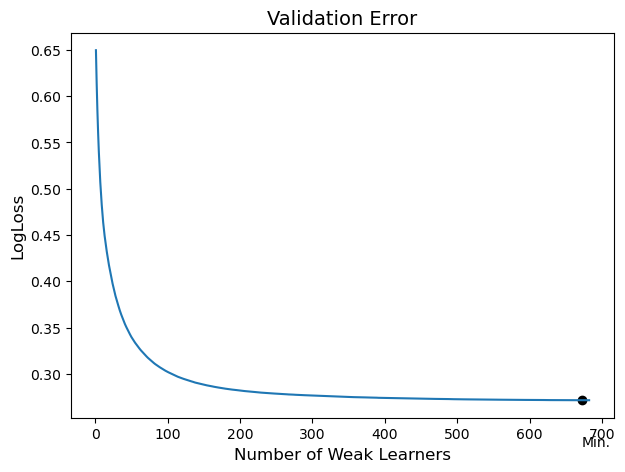

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['logloss'])+1), 
         xgb_reg.evals_result()['validation_0']['logloss'])
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['logloss'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['logloss'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['logloss'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['logloss'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['logloss'])], 
         np.min(xgb_reg.evals_result()['validation_0']['logloss'])-.05, "Min.", fontsize=10)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("LogLoss", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

In [11]:
# Do XGBoost with the best number of estimators (680)

xgb_reg_accs = np.zeros(shape=(n_splits))

i = 0
for train_index, test_index in kfold.split(train_data[features], train_data['isvandalism']):
    edits_tt = train_data.iloc[train_index]
    edits_ho = train_data.iloc[test_index]

    xgb_reg = xgboost.XGBClassifier(learning_rate=0.1, max_depth=1, n_estimators=680)
    xgb_reg.fit(edits_tt[features], edits_tt['isvandalism'])
    
    pred = xgb_reg.predict(edits_ho[features])
    xgb_reg_accs[i] = np.sum(pred == edits_ho['isvandalism'])/len(edits_ho['isvandalism'])

    i+=1

print(xgb_reg_accs)
print(np.average(xgb_reg_accs))

[0.87426442 0.87720675 0.87642213 0.87659407 0.87737885]
0.876373243347401


In [12]:
# XGBoost with vandalism score

features = ['is_IP', 'account_age', 'user_edit_count', 'user_warns', 'user_distinct_pages', 'num_recent_edits', 'num_recent_reversions', 'current_minor', 'vandalism_score']

xgb_reg = xgboost.XGBClassifier(learning_rate=.1, max_depth=1, n_estimators=680)
xgb_reg.fit(train_data[features], train_data['isvandalism'])
pred = xgb_reg.predict(test_data[features])

print(np.sum(pred == test_data['isvandalism'])/len(test_data['isvandalism']))
print(confusion_matrix(test_data['isvandalism'], pred))

0.8981481481481481
[[3118  155]
 [ 494 2605]]


In [13]:
# XGBoost with vandalism score and PCA engineering user credit score

features = ['user_credit', 'vandalism_score', 'num_recent_edits', 'num_recent_reversions', 'current_minor']

xgb_reg = xgboost.XGBClassifier(learning_rate=.1, max_depth=1, n_estimators=680)
xgb_reg.fit(train_data[features], train_data['isvandalism'])
pred = xgb_reg.predict(test_data[features])

print(np.sum(pred == test_data['isvandalism'])/len(test_data['isvandalism']))

0.8675455116133082
